# KS-testing on the IRIS Dataset
General Question: Are some features following the same distribution pattern? If yes, we can omit one of them
1. Load the data into a dataframe.
2. Compute the pairwise KS-Test for the numerical features
3. Draw conclusions if data can be omitted
4. Create the result data set

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

## 1. Load the data and check proper loading

In [4]:
%time data = pd.read_csv("./data.all", delimiter=' ', header=None,  names=['sl','sw','pl','pw','class'])
#%time data = pd.read_csv(r"./data/bimsim_31_day_sample.csv", delimiter=',')
data.head(5)

CPU times: total: 0 ns
Wall time: 6.48 ms


,sl,sw,pl,pw,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


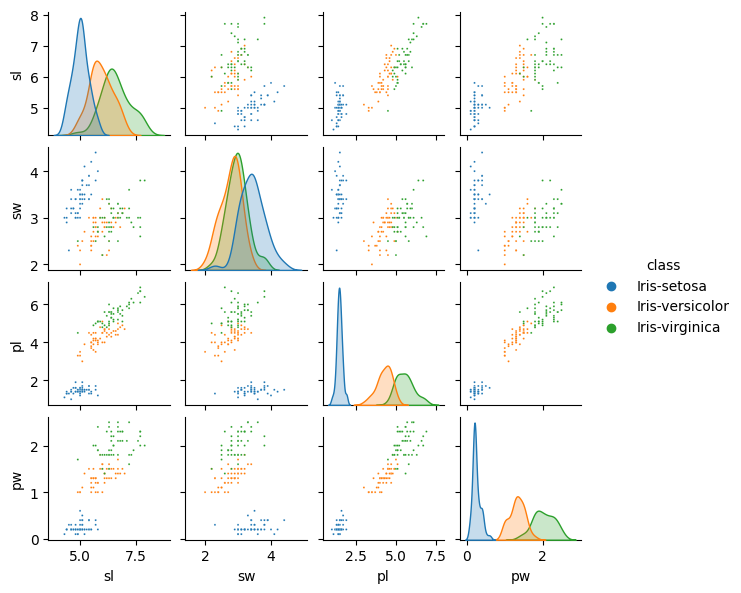

In [5]:
sns.pairplot(data, hue="class", height = 1.5, plot_kws={"s": 2})

The scatterplot shows a good linear correlation between pl and pw. But if we check the scales, we see that both have a very different range of values. The boxplot makes this apparent.

<Axes: >

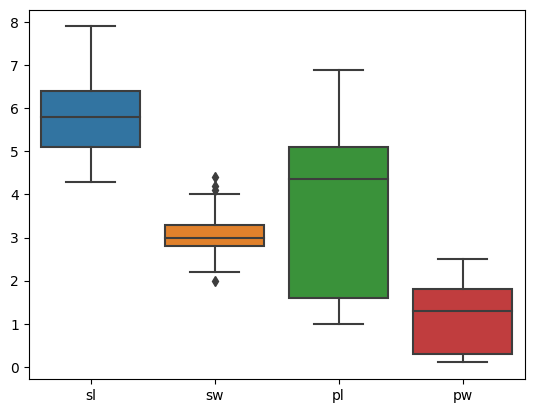

In [6]:
sns.boxplot(data)

## 2. Compute the pairwise KS-Test for the numerical features

Our Null and Alternative Hypotheses are:<br>
(1) $H_0\colon F_X(x) = F_Y(x)$<br>
(2) $H_1\colon F_X(x) \neq F_Y(x)$

$H_0$ := $X$ and $Y$ have the same probablity distribution<br>
$H_1$ := $X$ and $Y$ have the different probability distributions<br><br>

The KS-Test compares the results of the cumulative sum of both distributions and checks for the maximum distance:<br>
$F_{X,n}= \frac{ \text{Number of values in X Sample} \leq x}n = \frac{1}{n} \sum_{i=1}^n \mathbf{1}_{\{x_i \le x\}}$<br>
$F_{Y,m}= \frac{ \text{Number of values in Y Sample} \leq x}n = \frac{1}{n} \sum_{i=1}^n \mathbf{1}_{\{x_i \le x\}}$<br>
$d_{n,m}=\|F_{X,n}-F_{Y,m}\|=\sup_x|F_{X,n}(x)-F_{Y,m}(x)|$<br>


## 2.1 Explanation of Cumulative Distribution sum
Just for illustrative purposes, we will generate the picture of the original distribution and its cumulative sum, often known as Empirical (Cumulative) Distribution Function, E(C)DF.

To compare distributions, we have to normalize them to become a probability density function. Then we can compute the cumulative sum.

Note that we need to normalize per column in a dataframe, not the feature vectors themselves, which is something that is happening mostly for data preparation for modelling.

In [7]:
n_data = (data.iloc[:, 0:1])/data.iloc[:, 0:1].sum()

Now we can plot the raw data and its cumulative sum

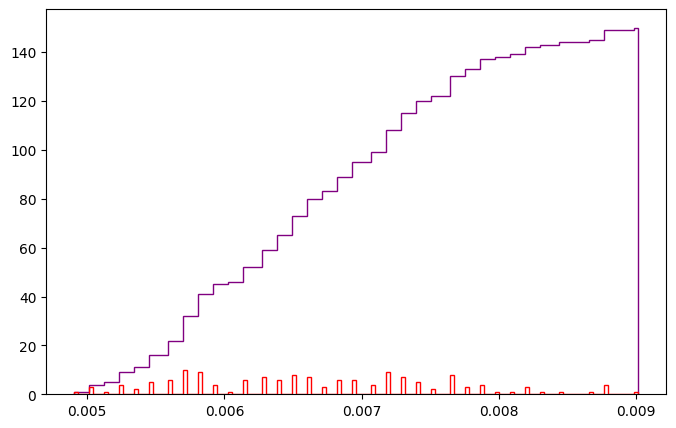

In [8]:
plt.subplots(figsize=(8, 5))
a, b, c = plt.hist(n_data[:], bins=n_data.shape[0], cumulative=True, label='EDF', 
         histtype='step', color='purple')
d, e, f = plt.hist(n_data[:], bins=n_data.shape[0], cumulative=False, label='Raw', 
         histtype='step', color='red')

Now, we do the pairwise KS-Test

In [9]:
data.shape

(150, 5)

## 2.2 Do a pairwise, two sided KS-Test for all features

### 2.2.0 Import required stuff and put pairwise KS-Testing into a function

In [10]:
from sklearn.preprocessing import minmax_scale

def pairwise_ks_test(data, names):
    res = pd.DataFrame(index = names, columns = names, dtype=float)
    for i in range(data.shape[1]):
        for j in range(data.shape[1]):
            res.iloc[i, j] = ks_2samp(data[:, i], data[:, j])[1]   # p-value of ks-test         
#            res.iloc[i, j] = ks_2samp(data[:, i], data[:, j], method='asymp')[0]   # D-value of ks-test         
    return res     

### 2.2.1 Normalize the data

E.g.use the minmax scaler (with a range of $[0, 1]$). 

Using a robust scaler can be applied as well, but in any case remember, that:
* for large scale data, the ks-test will quickly lead to a rejection of $H_0$, due to difference accumulation
* outliers in the data might have a large influence as well

### Preprocessing considerations
* For the Iris-dataset, we see a strong linear correlation between pw and pl. If we normalize the data (min-max) or pdf with offset correction, sl and sw seem to be stronger correlated (and have better p-Value in ks)
  <br>$\longrightarrow$ depending on the normalization values will change. This happens because e.g. the min-max-Normalization compensates for shifts and scale and focuses on shape only.  
* (q2) If we want to compare data, is it sufficient to transform both sequences into a pdf like distribution or don't we need to scale at all?
 <br>$\longrightarrow$ In general, your preprocessing should match your analysis question. If you are interested in a ks-result that is independant from shift and or scale, you have to preprocess your data in a way, that the features of interest have the same offset and scale, repsectively. E.g. Temperature shift and scale should be compensated if we want to compare °F and °C. General approach: Assess the data using ks-Test and scatter-tests (visually, on a subset if dataset is large). Look at the boxplots or the related statistics to see shifts and scales.
* (q3) Which transformation is the one to chose?
 <br>$\longrightarrow$ For the modelling stage, a specific type of normalization is often chosen. It is advisable to use this also in the preprocessing for the ks-test, as we then get insight, if the features of our dataset shall all be kept after the transformation

In [43]:
# no scaling
n_data = data.iloc[:, 0:4].to_numpy()

# correct for shift only
#n_data = (data.iloc[:, 0:4]-data.iloc[:, 0:4].min()).to_numpy()

# scale data to 0-1 Interval
#n_data = minmax_scale(data.iloc[:, 0:4], axis = 0) # we normalize only the numerical columns, columnwise

# eliminate shift by shifting the features' median to zero and scale according to their IQR
scaler = RobustScaler()
n_data = scaler.fit_transform(X=data.iloc[:, 0:4]) 

n_data_df = pd.DataFrame(n_data, columns = data.columns[0:4])
display("Original data", data.describe(), "Transformed data", pd.DataFrame(n_data, columns = data.columns[:-1]).describe())


'Original data'

,sl,sw,pl,pw
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


'Transformed data'

,sl,sw,pl,pw
count,150.000000,150.000000,1.500000e+02,150.000000
mean,0.033333,0.114667,-1.691429e-01,-0.067111
std,0.636974,0.871733,5.043709e-01,0.508158
min,-1.153846,-2.000000,-9.571429e-01,-0.800000
25%,-0.538462,-0.400000,-7.857143e-01,-0.666667
50%,0.000000,0.000000,1.266348e-16,0.000000
75%,0.461538,0.600000,2.142857e-01,0.333333
max,1.615385,2.800000,7.285714e-01,0.800000


<Axes: >

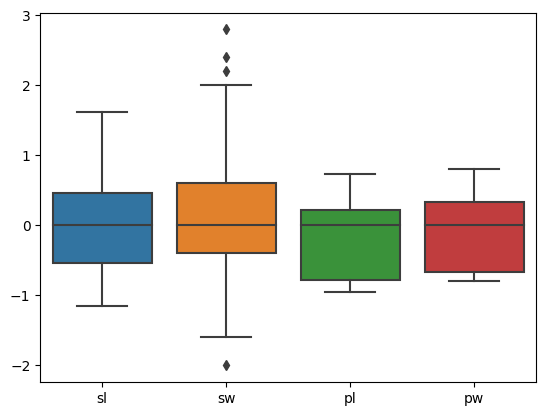

In [44]:
sns.boxplot(n_data_df)

Depending on the normalization, the data comes from a similar range of values. See App B for a detailed analysis.

### 2.2.2 Perform the pairwise KS-test 

In [45]:
raw_ks_test_results = pairwise_ks_test(data.iloc[:, 0:4].to_numpy(), data.columns[0:4])
ks_test_results = pairwise_ks_test(n_data, data.columns[0:4])
# %time ks_test_results = pairwise_ks_test(n_data, data.columns[4:7])
display(raw_ks_test_results, ks_test_results)

,sl,sw,pl,pw
sl,1.000000e+00,6.399338e-87,5.290397e-22,2.133113e-89
sw,6.399338e-87,1.000000e+00,4.092283e-23,8.600928e-66
pl,5.290397e-22,4.092283e-23,1.000000e+00,6.639808e-32
pw,2.133113e-89,8.600928e-66,6.639808e-32,1.000000e+00


,sl,sw,pl,pw
sl,1.000000,0.139062,0.000863,0.079310
sw,0.139062,1.000000,0.000042,0.000863
pl,0.000863,0.000042,1.000000,0.000008
pw,0.079310,0.000863,0.000008,1.000000


### 2.2.3 Comparison with correlation coefficients

In [46]:
data[['sl','sw','pl','pw']].corr()

,sl,sw,pl,pw
sl,1.000000,-0.117570,0.871754,0.817941
sw,-0.117570,1.000000,-0.428440,-0.366126
pl,0.871754,-0.428440,1.000000,0.962865
pw,0.817941,-0.366126,0.962865,1.000000


Although sl-pl and sl-pw show a high correlation, KS test results show, that they are not similar enough to drop one of them

## 3. Conclusion
From the result table we see, that only sl and sw have a p-Value of >5%: The measurements have different distributions, hence we should not omit any columns of the data.

## 4. Result set
As we cannot omit any data, we keep the original set

## Appendix A: Comparing min_max_scaler with hand made scaling

In [47]:
n_data_2_min = data.iloc[:, 0:4].min()
n_data_2_max = data.iloc[:, 0:4].max()
n_data_2 = (data.iloc[:, 0:4]-n_data_2_min)/(n_data_2_max - n_data_2_min) 

In [48]:
n_data_2.describe()-pd.DataFrame(n_data, columns = ['sl','sw','pl','pw']).describe()

,sl,sw,pl,pw
count,0.000000,0.000000,0.000000,0.000000
mean,0.395370,0.325889,0.636600,0.525167
std,-0.406956,-0.690122,-0.205168,-0.190559
min,1.153846,2.000000,0.957143,0.800000
25%,0.760684,0.733333,0.887409,0.750000
50%,0.416667,0.416667,0.567797,0.500000
75%,0.121795,-0.058333,0.480630,0.375000
max,-0.615385,-1.800000,0.271429,0.200000


We see, that there are only marginal differences in the results

In [49]:
ks_test_results_2 = pairwise_ks_test(n_data_2.to_numpy(), data.columns[0:4])

display(ks_test_results_2)

,sl,sw,pl,pw
sl,1.000000,0.079310,0.000204,0.000204
sw,0.079310,1.000000,0.000001,0.000042
pl,0.000204,0.000001,1.000000,0.004858
pw,0.000204,0.000042,0.004858,1.000000


In [50]:
ks_test_results_2- ks_test_results

,sl,sw,pl,pw
sl,0.000000,-0.059752,-0.000659,-0.079106
sw,-0.059752,0.000000,-0.000041,-0.000821
pl,-0.000659,-0.000041,0.000000,0.004850
pw,-0.079106,-0.000821,0.004850,0.000000


We see, that the difference in p-Value come from minor differences in the normalization

In [51]:
(n_data - n_data_2).sum()

sl   -59.305556
sw   -48.883333
pl   -95.490073
pw   -78.775000
dtype: float64

The small differences in the calculation of the normalization is already sufficient, to lead to a deviation of more than two percentage points in the calculation of the p-Values!

## Appendix B: Comparision of transformations and their distributions

We look at how the transformation operation on a single feature (e.g. MinMaxNormalization) changes the data. For both, the original and the transformed feature, a pairwise ks-test is performed

In [52]:
n_data_df.rename({"sl":"sl_t", "sw":"sw_t", "pl":"pl_t", "pw":"pw_t"}, axis=1, inplace = True)

In [53]:
n_data_df

,sl_t,sw_t,pl_t,pw_t
0,-0.538462,1.0,-0.842857,-0.733333
1,-0.692308,0.0,-0.842857,-0.733333
2,-0.846154,0.4,-0.871429,-0.733333
3,-0.923077,0.2,-0.814286,-0.733333
4,-0.615385,1.2,-0.842857,-0.733333
...,...,...,...,...
145,0.692308,0.0,0.242857,0.666667
146,0.384615,-1.0,0.185714,0.400000
147,0.538462,0.0,0.242857,0.466667
148,0.307692,0.8,0.300000,0.666667


In [54]:
all_data = pd.concat([n_data_df, data], axis = 1)

In [55]:
all_data

,sl_t,sw_t,pl_t,pw_t,sl,sw,pl,pw,class
0,-0.538462,1.0,-0.842857,-0.733333,5.1,3.5,1.4,0.2,Iris-setosa
1,-0.692308,0.0,-0.842857,-0.733333,4.9,3.0,1.4,0.2,Iris-setosa
2,-0.846154,0.4,-0.871429,-0.733333,4.7,3.2,1.3,0.2,Iris-setosa
3,-0.923077,0.2,-0.814286,-0.733333,4.6,3.1,1.5,0.2,Iris-setosa
4,-0.615385,1.2,-0.842857,-0.733333,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...,...,...,...
145,0.692308,0.0,0.242857,0.666667,6.7,3.0,5.2,2.3,Iris-virginica
146,0.384615,-1.0,0.185714,0.400000,6.3,2.5,5.0,1.9,Iris-virginica
147,0.538462,0.0,0.242857,0.466667,6.5,3.0,5.2,2.0,Iris-virginica
148,0.307692,0.8,0.300000,0.666667,6.2,3.4,5.4,2.3,Iris-virginica


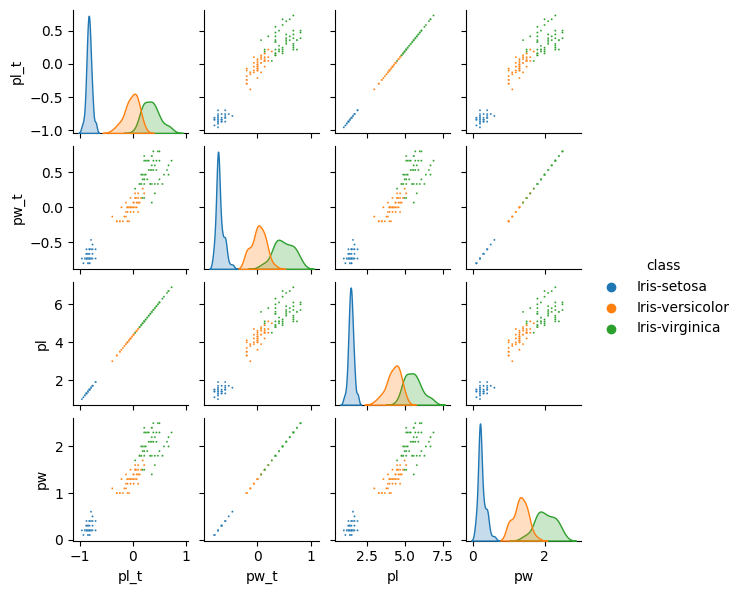

In [56]:
sns.pairplot(all_data[["pl_t", "pw_t", "pl", "pw", "class"]], hue="class", height = 1.5, plot_kws={"s": 2})

The scattermatrix shows that the transformed features are perfectly linearly correlated with their original. This can be seen from the computation of the correlation coefficients as well. But the scales (shifts and slopes) are different. Hence the difference in the ks-test.

In [25]:
all_data[["pl_t", "pw_t", "pl", "pw"]].corr()

,pl_t,pw_t,pl,pw
pl_t,1.000000,0.962865,1.000000,0.962865
pw_t,0.962865,1.000000,0.962865,1.000000
pl,1.000000,0.962865,1.000000,0.962865
pw,0.962865,1.000000,0.962865,1.000000


In [26]:
pairwise_ks_test(all_data[["pl_t", "pw_t", "pl", "pw"]].to_numpy(), names = ["pl_c", "pw_c", "pl", "pw"])

,pl_c,pw_c,pl,pw
pl_c,1.000000e+00,7.292849e-30,8.870018e-08,1.492014e-28
pw_c,7.292849e-30,1.000000e+00,6.639808e-32,3.347341e-04
pl,8.870018e-08,6.639808e-32,1.000000e+00,6.639808e-32
pw,1.492014e-28,3.347341e-04,6.639808e-32,1.000000e+00


we see, that the normalization operation modifies the data in a way (e.g. correcting for a shift) that the resulting feature is dissimilar to the original feature in the sense of a ks-test

<Axes: >

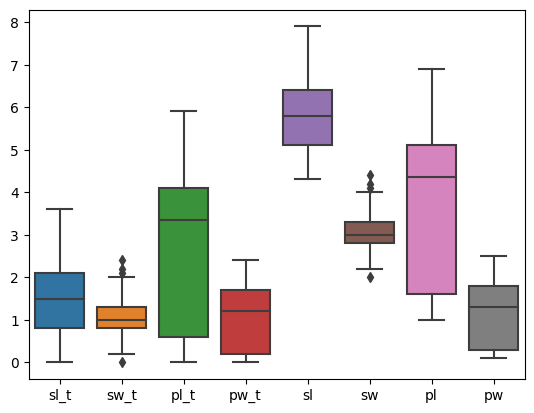

In [27]:
sns.boxplot(all_data)

## Appendix C: KS Test for a single feature with shift and scale

In [57]:
newData = pd.DataFrame(data["pw"])

In [58]:
newData["pw_sh"] = data["pw"]+1
newData["pw_sc"] = data["pw"]*2
newData["pw_shsc"] = (data["pw"]+1)*2


In [60]:
newData

,pw,pw_sh,pw_sc,pw_shsc
0,0.2,1.2,0.4,2.4
1,0.2,1.2,0.4,2.4
2,0.2,1.2,0.4,2.4
3,0.2,1.2,0.4,2.4
4,0.2,1.2,0.4,2.4
...,...,...,...,...
145,2.3,3.3,4.6,6.6
146,1.9,2.9,3.8,5.8
147,2.0,3.0,4.0,6.0
148,2.3,3.3,4.6,6.6


In [61]:
pairwise_ks_test(newData.to_numpy(), names = newData.columns)

,pw,pw_sh,pw_sc,pw_shsc
pw,1.000000e+00,1.799621e-16,1.485814e-22,7.863678e-70
pw_sh,1.799621e-16,1.000000e+00,1.756439e-07,6.639808e-32
pw_sc,1.485814e-22,1.756439e-07,1.000000e+00,1.799621e-16
pw_shsc,7.863678e-70,6.639808e-32,1.799621e-16,1.000000e+00


In [32]:
pairwise_ks_test(minmax_scale(newData.iloc[:, 0:4], axis = 0), names = newData.columns)

,pw,pw_sh,pw_sc,pw_shsc
pw,1.000000,0.007227,1.000000,0.007227
pw_sh,0.007227,1.000000,0.007227,1.000000
pw_sc,1.000000,0.007227,1.000000,0.007227
pw_shsc,0.007227,1.000000,0.007227,1.000000


In [33]:
pairwise_ks_test((newData.iloc[:, 0:4]-newData.iloc[:, 0:4].min()).to_numpy(), names = newData.columns)

,pw,pw_sh,pw_sc,pw_shsc
pw,1.000000e+00,7.226677e-03,6.331058e-21,5.290397e-22
pw_sh,7.226677e-03,1.000000e+00,6.331058e-21,5.290397e-22
pw_sc,6.331058e-21,6.331058e-21,1.000000e+00,7.226677e-03
pw_shsc,5.290397e-22,5.290397e-22,7.226677e-03,1.000000e+00


In [34]:
(newData.iloc[:, 0:4]-newData.iloc[:, 0:4].min()).describe()

,pw,pw_sh,pw_sc,pw_shsc
count,150.000000,150.000000,150.000000,150.000000
mean,1.099333,1.099333,2.198667,2.198667
std,0.762238,0.762238,1.524475,1.524475
min,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.200000,0.400000,0.400000
50%,1.200000,1.200000,2.400000,2.400000
75%,1.700000,1.700000,3.400000,3.400000
max,2.400000,2.400000,4.800000,4.800000


In [35]:
ttt = newData.iloc[:, 0:4]-newData.iloc[:, 0:4].min()

In [36]:
ttt["pw"] - ttt["pw_sh"]

0      1.387779e-16
1      1.387779e-16
2      1.387779e-16
3      1.387779e-16
4      1.387779e-16
           ...     
145    0.000000e+00
146    0.000000e+00
147    0.000000e+00
148    0.000000e+00
149    2.220446e-16
Length: 150, dtype: float64

In [37]:
(ttt["pw"] - ttt["pw_sh"]).sum()

1.0658141036401503e-14

The small differences in the data already lead to strong decrease in the p-Value of the ks-test. Still $H_0$ holds.

<Axes: >

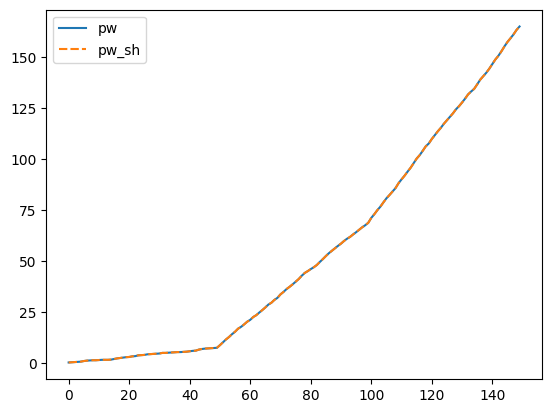

In [38]:
sns.lineplot(ttt[["pw", "pw_sh"]].cumsum())